## Modulation Recognition: 2018.01A Dataset

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1712.04578

The RML2018.01a dataset is used for this work (https://www.deepsig.io/datasets)


In [1]:
# Import all the things we need 
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from keras.utils import np_utils
import keras.models as models
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GaussianNoise, BatchNormalization
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\comp

In [2]:
# Fix tensorflow backend error when using keras
# https://github.com/keras-team/keras/issues/13684
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


In [3]:
# Turn on memory growth (https://www.tensorflow.org/guide/gpu)
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

# Dataset setup

In [4]:
import h5py

filename = "GOLD_XYZ_OSC.0001_1024.hdf5"

def load_hdf5(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        keys = list(f.keys())
        X = f.get(keys[0])[:]
        Y = f.get(keys[1])[:]
        Z = f.get(keys[2])[:]
    return X, Y, Z

X, Y, Z = load_hdf5(filename) # this may take up to a minute

Keys: <KeysViewHDF5 ['X', 'Y', 'Z']>


In [5]:
print(X.shape) # Input (radio signal data)
print(Y.shape) # Target values (in one-hot encoding)
print(Z.shape) # Signal to noise ratios
print('')
print("Signal to noise ratio")
print(np.unique(Z, return_counts=True)[0])
print("{} ratios with {} samples each".format(np.unique(Z).shape[0], np.unique(Z, return_counts=True)[1][0]))
print('')
classes = np.array(['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK',
 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC', 'OOK', '16QAM'])
easy_classes = np.array([22, 11, 8, 19, 9, 23, 10, 16, 3, 4, 6])
print("Easy Modulations: {}".format(classes[easy_classes]))
print("All Modulations: {}".format(classes))

(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)

Signal to noise ratio
[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
26 ratios with 98304 samples each

Easy Modulations: ['OOK' '4ASK' 'BPSK' 'QPSK' '8PSK' '16QAM' 'AM-SSB-SC' 'AM-DSB-SC' 'FM'
 'GMSK' 'OQPSK']
All Modulations: ['32PSK' '16APSK' '32QAM' 'FM' 'GMSK' '32APSK' 'OQPSK' '8ASK' 'BPSK'
 '8PSK' 'AM-SSB-SC' '4ASK' '16PSK' '64APSK' '128QAM' '128APSK' 'AM-DSB-SC'
 'AM-SSB-WC' '64QAM' 'QPSK' '256QAM' 'AM-DSB-WC' 'OOK' '16QAM']


In [6]:
# use only SNRs > -12
indices = np.where(Z>=-14)[0]
X = X[indices]
Y = Y[indices]
Z = Z[indices]

print("X.shape: {}".format(X.shape))
print("Y.shape: {}".format(Y.shape))

X.shape: (2260992, 1024, 2)
Y.shape: (2260992, 24)


In [7]:
# Partition into training and test datasets (https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros)
def get_train_test_inds(y,train_proportion=0.5):
    '''Generates indices, making random stratified split into training set and testing sets
    with proportions train_proportion and (1-train_proportion) of initial sample.
    y is any iterable indicating classes of each observation in the sample.
    Initial proportions of classes inside training and 
    testing sets are preserved (stratified sampling).
    '''

    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y, axis=0)
    for value in values:
        value_inds = (y==value).all(axis=1).nonzero()[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds

train_inds,test_inds = get_train_test_inds(Y,train_proportion=0.5)
X_train = X[train_inds]
Y_train = Y[train_inds]
X_test = X[test_inds]
Y_test = Y[test_inds]
in_shp = list(X_train.shape[1:])

In [8]:
print("X_train.shape: {}".format(X_train.shape))
print("Y_train.shape: {}".format(Y_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("Y_test.shape: {}".format(Y_test.shape))
print("input shape: {}".format(in_shp))

X_train.shape: (1130496, 1024, 2)
Y_train.shape: (1130496, 24)
X_test.shape: (1130496, 1024, 2)
Y_test.shape: (1130496, 24)
input shape: [1024, 2]


# Build the NN Model

In [9]:
keras.backend.clear_session()

dr = 0.5 # dropout rate 
lr = 0.001 # learing rate
l2_reg = 0.00

model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
# Layer 1
model.add(Conv2D(64, (1, 3), padding="same", name="conv1", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
# Layer 2
model.add(Conv2D(64, (1, 3), padding="same", name="conv2", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
# Layer 3
model.add(Conv2D(64, (1, 3), padding="same", name="conv3", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
# Layer 4
model.add(Conv2D(64, (1, 3), padding="same", name="conv4", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
# Layer 5
model.add(Conv2D(64, (1, 3), padding="same", name="conv5", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
# Layer 6
model.add(Conv2D(64, (1, 3), padding="same", name="conv6", kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(1, 16)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(len(classes), kernel_initializer='he_normal', name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1024, 2)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 1024, 64)       448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1024, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1024, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 512, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 512, 64)        12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 512, 64)       

In [10]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 512  # training batch size, use highest possible power of two without getting oom

# Train the Model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'rml2018.wts.h5'
history = model.fit(X_train,
    Y_train,1
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=0,
    validation_data=(X_test, Y_test),
    callbacks = [
        TQDMNotebookCallback(),  # for progress bar
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

# Takes 20-30 mins for one SNR: 10
# 74 mins for 4 SNRs: 12, 18, 24, 30
# 6-7 hours for 16 SNRs: -12 - 18
# 5 hours for 22 SNRs: -12 - 30
# 7 hours for 23 SNRs: -14 - 30
# If you get the error : Failed to get convolution algorithm, that probably means you're out of memory. Shut down all kernels and rerun the notebook.

In [12]:
# Load model from before
# filepath = 'rml2018.wts.h5'
# model.load_weights(filepath)

# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("loss: {}".format(score[0]))
print("accuracy: {}".format(score[1]))

loss: 1.000314913899893
accuracy: 0.6392636299133301


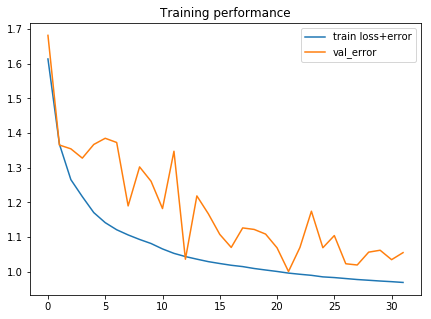

In [14]:
# Show loss curve
plt.figure(figsize=(7,5))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    #plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Save figure to image file
    # plt.savefig("../images/2018_MyNN_SNR{}_easy".format(snr), bbox_inches='tight')
    plt.show()

In [16]:
snrs = np.unique(Z)
snrs = snrs[snrs>=-14]
snrs

array([-14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,
        12,  14,  16,  18,  20,  22,  24,  26,  28,  30], dtype=int64)

In [22]:
# # Adjust font sizes for figures
# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'large',
#          'axes.labelsize': 'large',
#          'axes.titlesize':'xx-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


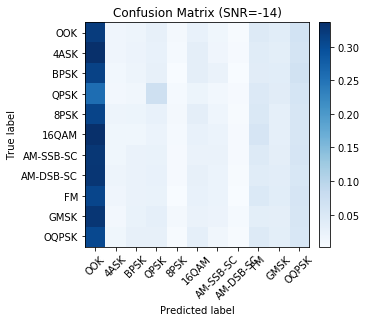


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
      16APSK       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.09      0.03      0.04      2078
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
       32QAM       0.00      0.00      0.00         0
        4ASK       0.10      0.02      0.03      2050
      64APSK       0.00      0.00      0.00         0
       64QAM       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.12      0.01      0.01      2007
   AM-DSB-SC       0.08      0.00      0.01      2049
   AM-DSB-WC       0.00      0.00      0.00         0
   AM-SSB-SC       0.12      0.02      0.04      2082
   A

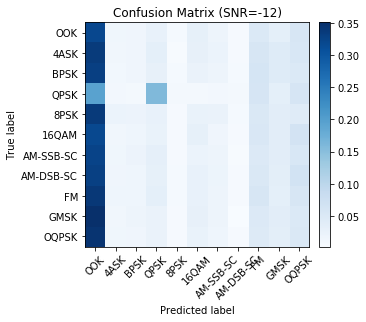


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
      16APSK       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.11      0.03      0.05      2052
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
       32QAM       0.00      0.00      0.00         0
        4ASK       0.08      0.01      0.02      2033
      64APSK       0.00      0.00      0.00         0
       64QAM       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.07      0.00      0.01      2073
   AM-DSB-SC       0.10      0.00      0.01      2040
   AM-DSB-WC       0.00      0.00      0.00         0
   AM-SSB-SC       0.09      0.02      0.03      2034
   A

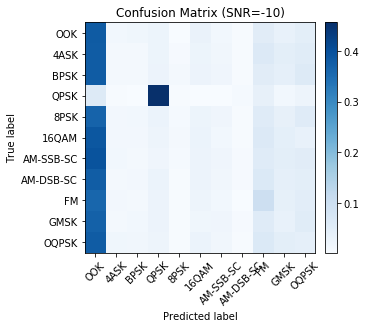


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
      16APSK       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.11      0.03      0.05      2037
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
       32QAM       0.00      0.00      0.00         0
        4ASK       0.08      0.01      0.02      2031
      64APSK       0.00      0.00      0.00         0
       64QAM       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.11      0.01      0.01      2005
   AM-DSB-SC       0.13      0.01      0.01      2080
   AM-DSB-WC       0.00      0.00      0.00         0
   AM-SSB-SC       0.12      0.02      0.04      2093
    

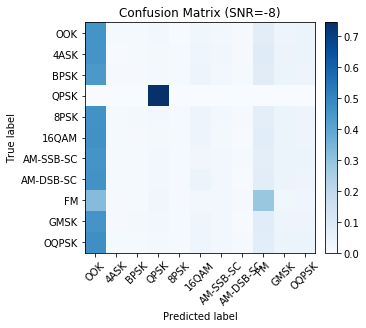


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
      16APSK       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.12      0.04      0.06      2073
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
       32QAM       0.00      0.00      0.00         0
        4ASK       0.06      0.00      0.01      2018
      64APSK       0.00      0.00      0.00         0
       64QAM       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.08      0.01      0.01      2119
   AM-DSB-SC       0.07      0.01      0.01      2004
   AM-DSB-WC       0.00      0.00      0.00         0
   AM-SSB-SC       0.11      0.02      0.04      2036
    

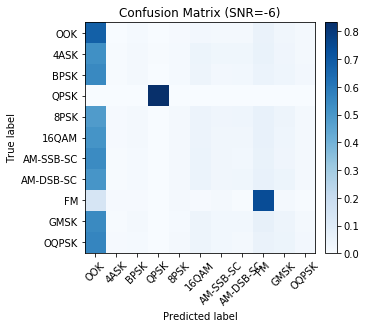


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
      16APSK       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.12      0.05      0.07      2051
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
       32QAM       0.00      0.00      0.00         0
        4ASK       0.07      0.00      0.01      2087
      64APSK       0.00      0.00      0.00         0
       64QAM       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.13      0.02      0.03      2071
   AM-DSB-SC       0.13      0.03      0.05      2073
   AM-DSB-WC       0.00      0.00      0.00         0
   AM-SSB-SC       0.10      0.03      0.04      2055
    

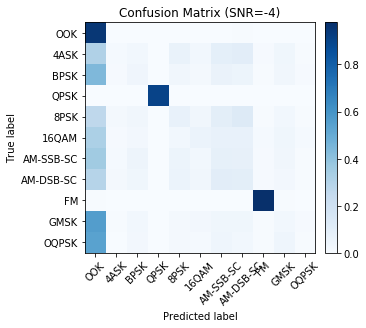


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.25      0.06      0.10      2090
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
       32PSK       0.00      0.00      0.00         0
        4ASK       0.14      0.01      0.03      2041
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.21      0.07      0.11      2041
   AM-DSB-SC       0.17      0.10      0.12      2080
   AM-SSB-SC       0.14      0.08      0.10      2023
        BPSK       0.15      0.04      0.07      2028
          FM       0.94      0.98      0.96      1998
        GMSK       0.10      0.03      0.04      2049
         OOK       0.24      0.95      0.38      2075
    

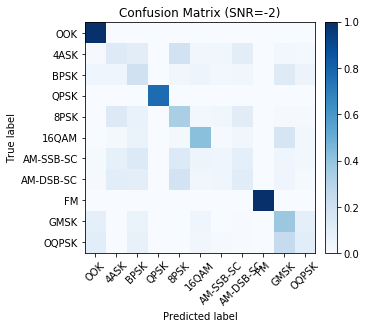


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.61      0.42      0.50      2091
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.24      0.12      0.16      2003
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.38      0.34      0.36      2054
   AM-DSB-SC       0.23      0.11      0.15      2066
   AM-SSB-SC       0.20      0.04      0.07      2041
        BPSK       0.24      0.20      0.22      2046
          FM       1.00      1.00      1.00      2027
        GMSK       0.37      0.38      0.38      2110
         OOK       0.77      1.00      0.87      1999
       OQPSK       0.30      0.11      0.16      2098
    

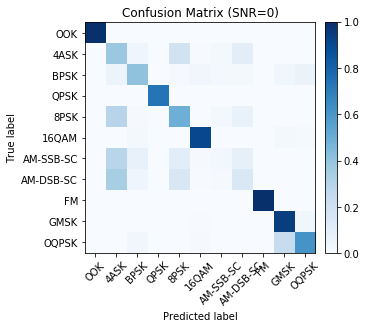


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       0.93      0.91      0.92      2007
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.28      0.38      0.32      2035
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.53      0.49      0.51      2099
   AM-DSB-SC       0.35      0.15      0.20      2046
   AM-SSB-SC       0.31      0.03      0.06      2043
        BPSK       0.64      0.41      0.50      2042
          FM       1.00      1.00      1.00      2096
        GMSK       0.76      0.95      0.84      2018
         OOK       1.00      1.00      1.00      2058
       OQPSK       0.84      0.61      0.71      2023
    

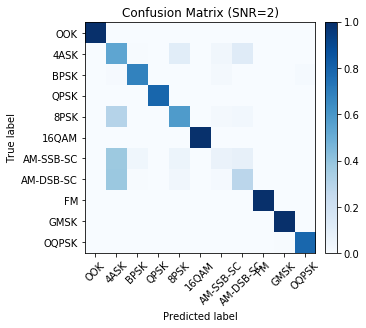


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      1977
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.33      0.54      0.41      2066
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.75      0.58      0.66      2085
   AM-DSB-SC       0.55      0.28      0.37      2050
   AM-SSB-SC       0.42      0.07      0.11      2057
        BPSK       0.92      0.68      0.78      2015
          FM       1.00      1.00      1.00      2042
        GMSK       0.99      1.00      1.00      2022
         OOK       1.00      1.00      1.00      2019
       OQPSK       0.98      0.79      0.87      2028
    

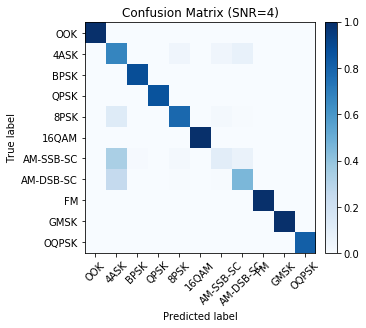


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2064
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.49      0.67      0.56      2072
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.93      0.78      0.85      2071
   AM-DSB-SC       0.76      0.46      0.57      2078
   AM-SSB-SC       0.62      0.10      0.18      2030
        BPSK       0.98      0.88      0.93      2080
          FM       1.00      1.00      1.00      2042
        GMSK       1.00      1.00      1.00      2071
         OOK       1.00      1.00      1.00      2107
       OQPSK       1.00      0.82      0.90      2031
    

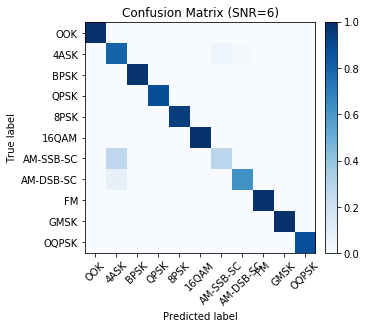


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2065
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.70      0.80      0.75      2080
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       0.99      0.95      0.97      2044
   AM-DSB-SC       0.96      0.63      0.76      2048
   AM-SSB-SC       0.85      0.29      0.43      2060
        BPSK       1.00      0.98      0.99      2065
          FM       1.00      1.00      1.00      2078
        GMSK       1.00      1.00      1.00      2039
         OOK       1.00      1.00      1.00      2041
       OQPSK       1.00      0.88      0.94      2041
    

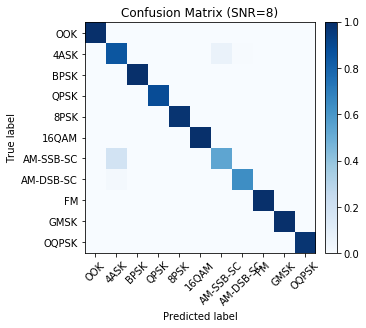


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2066
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.81      0.86      0.83      2031
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.98      0.99      2058
   AM-DSB-SC       0.99      0.64      0.78      2032
   AM-SSB-SC       0.89      0.54      0.67      2027
        BPSK       1.00      1.00      1.00      2052
          FM       1.00      1.00      1.00      2046
        GMSK       1.00      1.00      1.00      2069
         OOK       1.00      1.00      1.00      2089
       OQPSK       1.00      0.98      0.99      2018
    

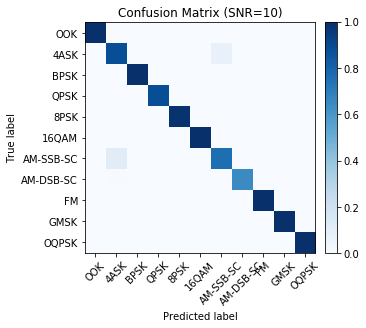


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2055
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.88      0.88      0.88      2060
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      0.99      2082
   AM-DSB-SC       1.00      0.65      0.79      2006
   AM-SSB-SC       0.91      0.76      0.83      2035
        BPSK       1.00      1.00      1.00      2013
          FM       1.00      1.00      1.00      2045
        GMSK       1.00      1.00      1.00      2027
         OOK       1.00      1.00      1.00      2052
       OQPSK       1.00      1.00      1.00      2089
    

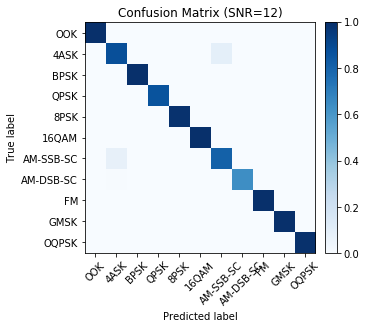


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2012
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.91      0.88      0.90      2037
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      2136
   AM-DSB-SC       1.00      0.64      0.78      2018
   AM-SSB-SC       0.90      0.81      0.85      2091
        BPSK       1.00      1.00      1.00      2078
          FM       1.00      1.00      1.00      2012
        GMSK       1.00      1.00      1.00      2046
         OOK       1.00      1.00      1.00      2047
       OQPSK       1.00      1.00      1.00      2023
    

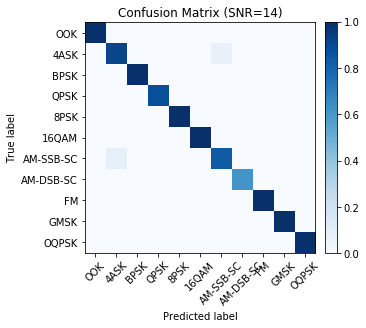


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2028
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.91      0.91      0.91      2102
      64APSK       0.00      0.00      0.00         0
        8PSK       1.00      1.00      1.00      2031
   AM-DSB-SC       1.00      0.61      0.76      2074
   AM-SSB-SC       0.92      0.83      0.87      2021
        BPSK       1.00      1.00      1.00      2014
          FM       1.00      1.00      1.00      2017
        GMSK       1.00      1.00      1.00      2032
         OOK       1.00      1.00      1.00      2053
       OQPSK       1.00      1.00      1.00      2088
        QPSK       1.00      0.88      0.94      2009

   

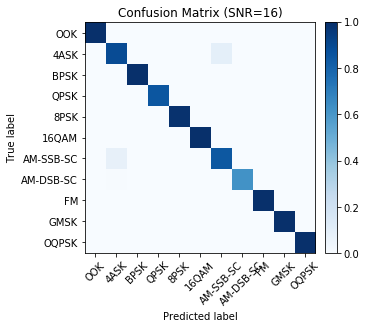


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2042
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.91      0.89      0.90      2069
      64APSK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      2019
   AM-DSB-SC       1.00      0.62      0.77      2041
   AM-SSB-SC       0.90      0.84      0.87      2070
        BPSK       1.00      1.00      1.00      2075
          FM       1.00      1.00      1.00      1989
        GMSK       1.00      1.00      1.00      2004
         OOK       1.00      1.00      1.00      2063
       OQPSK       1.00      1.00      1.00      2070
        QPSK       1.00      0.85      0.92      2045

   

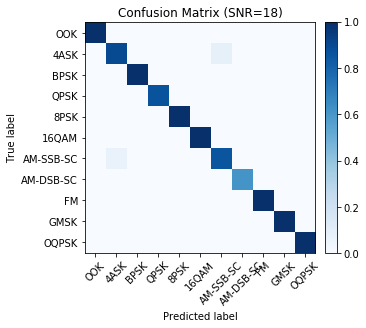


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2076
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.93      0.90      0.91      2061
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      2019
   AM-DSB-SC       1.00      0.62      0.76      2053
   AM-SSB-SC       0.91      0.86      0.89      2111
        BPSK       1.00      1.00      1.00      2039
          FM       1.00      1.00      1.00      2056
        GMSK       1.00      1.00      1.00      2066
         OOK       1.00      1.00      1.00      2113
       OQPSK       1.00      1.00      1.00      1993
    

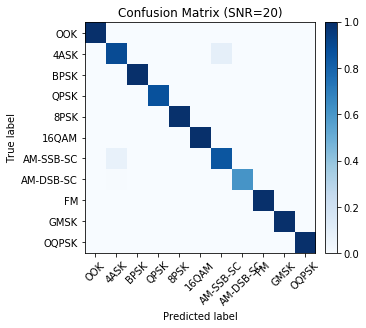


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2067
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.91      0.89      0.90      1966
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      0.99      1985
   AM-DSB-SC       1.00      0.61      0.76      2031
   AM-SSB-SC       0.91      0.85      0.88      2036
        BPSK       1.00      1.00      1.00      2018
          FM       1.00      1.00      1.00      2053
        GMSK       1.00      1.00      1.00      1979
         OOK       1.00      1.00      1.00      1998
       OQPSK       1.00      1.00      1.00      2060
    

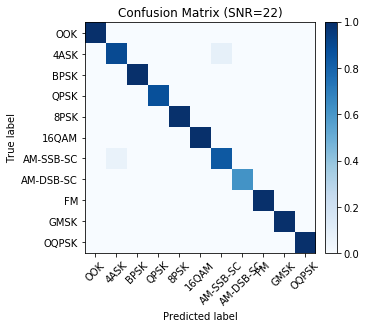


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2037
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.92      0.90      0.91      2083
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      1.00      1.00      1984
   AM-DSB-SC       1.00      0.62      0.76      2071
   AM-SSB-SC       0.91      0.84      0.87      2099
        BPSK       1.00      1.00      1.00      2061
          FM       1.00      1.00      1.00      2055
        GMSK       1.00      1.00      1.00      2025
         OOK       1.00      1.00      1.00      2063
       OQPSK       1.00      1.00      1.00      2034
    

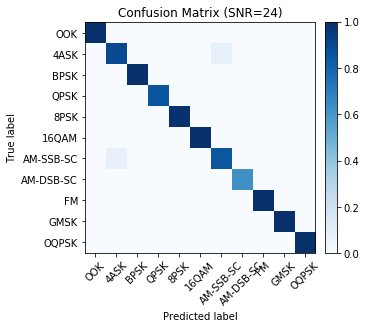


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2045
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.92      0.90      0.91      2023
      64APSK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      2050
   AM-DSB-SC       1.00      0.63      0.77      2034
   AM-SSB-SC       0.91      0.85      0.88      2069
        BPSK       1.00      1.00      1.00      2058
          FM       1.00      1.00      1.00      2051
        GMSK       1.00      1.00      1.00      2059
         OOK       1.00      1.00      1.00      2044
       OQPSK       1.00      1.00      1.00      2025
        QPSK       1.00      0.86      0.92      2027

   

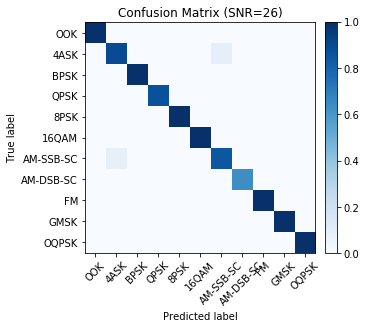


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2044
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.92      0.89      0.91      2111
      64APSK       0.00      0.00      0.00         0
        8PSK       1.00      1.00      1.00      2046
   AM-DSB-SC       1.00      0.64      0.78      2059
   AM-SSB-SC       0.90      0.85      0.87      2005
        BPSK       1.00      1.00      1.00      2013
          FM       1.00      1.00      1.00      2032
        GMSK       1.00      1.00      1.00      2081
         OOK       1.00      1.00      1.00      2026
       OQPSK       1.00      1.00      1.00      2107
        QPSK       1.00      0.87      0.93      2054

   

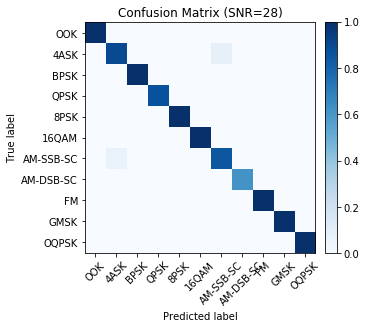


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2003
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.93      0.90      0.91      2014
      64APSK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      2038
   AM-DSB-SC       1.00      0.62      0.76      2020
   AM-SSB-SC       0.91      0.85      0.88      1983
        BPSK       1.00      1.00      1.00      2029
          FM       1.00      1.00      1.00      2059
        GMSK       1.00      1.00      1.00      2050
         OOK       1.00      1.00      1.00      2019
       OQPSK       1.00      1.00      1.00      2031
        QPSK       1.00      0.87      0.93      2047

   

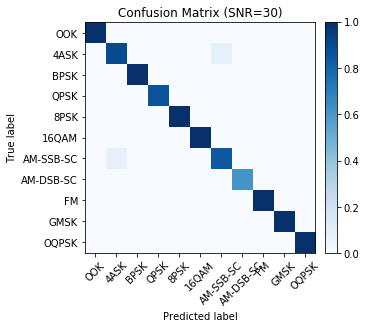


Clasification report:
              precision    recall  f1-score   support

     128APSK       0.00      0.00      0.00         0
      128QAM       0.00      0.00      0.00         0
       16PSK       0.00      0.00      0.00         0
       16QAM       1.00      1.00      1.00      2044
      256QAM       0.00      0.00      0.00         0
      32APSK       0.00      0.00      0.00         0
        4ASK       0.91      0.90      0.90      2031
      64APSK       0.00      0.00      0.00         0
        8ASK       0.00      0.00      0.00         0
        8PSK       1.00      0.99      1.00      1987
   AM-DSB-SC       1.00      0.61      0.76      2051
   AM-SSB-SC       0.91      0.85      0.88      2003
        BPSK       1.00      1.00      1.00      2027
          FM       1.00      1.00      1.00      2055
        GMSK       1.00      1.00      1.00      2046
         OOK       1.00      1.00      1.00      2022
       OQPSK       1.00      1.00      1.00      2073
    

In [22]:
# Plot confusion matrix for easy modulations

num_classes = classes.shape[0]
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = Z[test_inds]
    test_X_i = X_test[np.where(test_SNRs==snr)[0]]
    test_Y_i = Y_test[np.where(test_SNRs==snr)[0]]    
    test_Y_i = np.argmax(test_Y_i, axis=1)
    easy_idx = np.isin(test_Y_i, easy_classes)
    test_X_i = test_X_i[easy_idx]
    test_Y_i = test_Y_i[easy_idx]
    
    # estimate classes
    test_Y_i_predicted = model.predict(test_X_i)
    test_Y_i_predicted = np.argmax(test_Y_i_predicted, axis=1)
    conf = np.zeros([num_classes,num_classes])
    confnorm = np.zeros([num_classes,num_classes])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = test_Y_i_predicted[i]
        conf[j,k] = conf[j,k] + 1
    for i in range(num_classes):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    confnorm = confnorm[np.ix_(easy_classes, easy_classes)]
    conf = conf[np.ix_(easy_classes, easy_classes)]
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confnorm, labels=classes[easy_classes], title="Confusion Matrix (SNR=%d)"%(snr))
    
    # convert to modulation labels for display
    test_Y_i = classes[test_Y_i]
    test_Y_i_predicted = classes[test_Y_i_predicted]
    print('\nClasification report:\n{}'.format(metrics.classification_report(test_Y_i, test_Y_i_predicted, zero_division=0)))    
    # warnings indicate that some labels did not appear in the predictions at all

<Figure size 720x720 with 0 Axes>

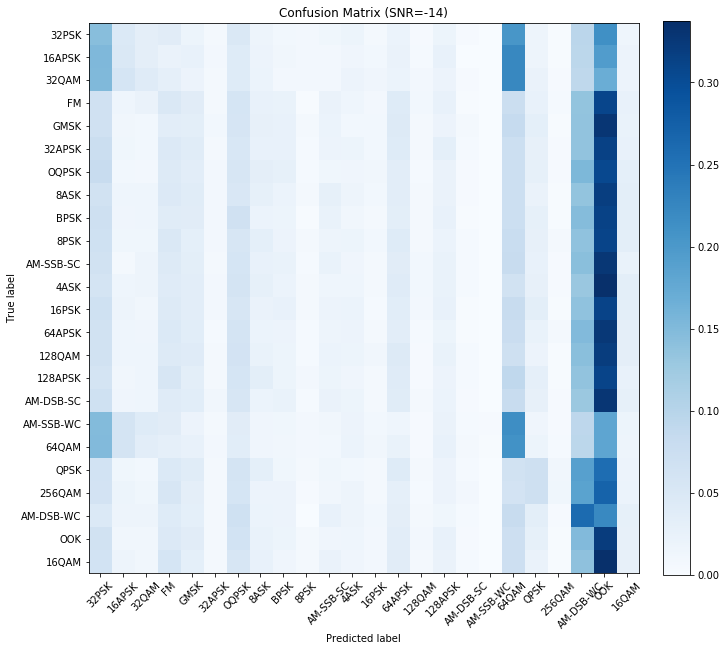

SNR=-14: Overall Accuracy = 0.059808128238341966

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.04      0.02      0.03      2030
      128QAM       0.03      0.00      0.01      2040
      16APSK       0.09      0.05      0.06      1975
       16PSK       0.02      0.00      0.01      2037
       16QAM       0.04      0.03      0.03      2078
      256QAM       0.13      0.01      0.02      2074
      32APSK       0.04      0.01      0.01      2010
       32PSK       0.07      0.14      0.10      2046
       32QAM       0.10      0.04      0.06      2167
        4ASK       0.04      0.02      0.02      2050
      64APSK       0.04      0.04      0.04      2093
       64QAM       0.08      0.21      0.12      2040
        8ASK       0.05      0.03      0.04      2090
        8PSK       0.05      0.01      0.01      2007
   AM-DSB-SC       0.04      0.00      0.01      2049
   AM-DSB-WC       0.08      0.26      0.12      2057
   AM-SSB

<Figure size 720x720 with 0 Axes>

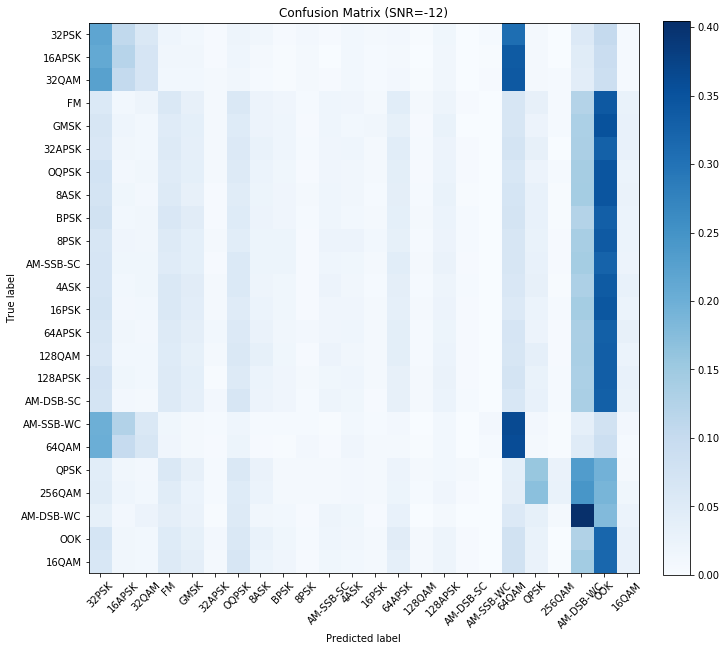

SNR=-12: Overall Accuracy = 0.08452538406755519

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.05      0.03      0.04      2027
      128QAM       0.05      0.01      0.01      2042
      16APSK       0.14      0.12      0.13      2011
       16PSK       0.04      0.01      0.01      2002
       16QAM       0.06      0.03      0.04      2052
      256QAM       0.21      0.03      0.05      2058
      32APSK       0.05      0.01      0.01      2063
       32PSK       0.10      0.22      0.13      2084
       32QAM       0.12      0.07      0.09      2032
        4ASK       0.04      0.01      0.02      2033
      64APSK       0.06      0.04      0.05      2053
       64QAM       0.13      0.36      0.19      2075
        8ASK       0.04      0.02      0.03      2046
        8PSK       0.03      0.00      0.01      2073
   AM-DSB-SC       0.06      0.00      0.01      2040
   AM-DSB-WC       0.12      0.40      0.19      2018
   AM-SSB-

<Figure size 720x720 with 0 Axes>

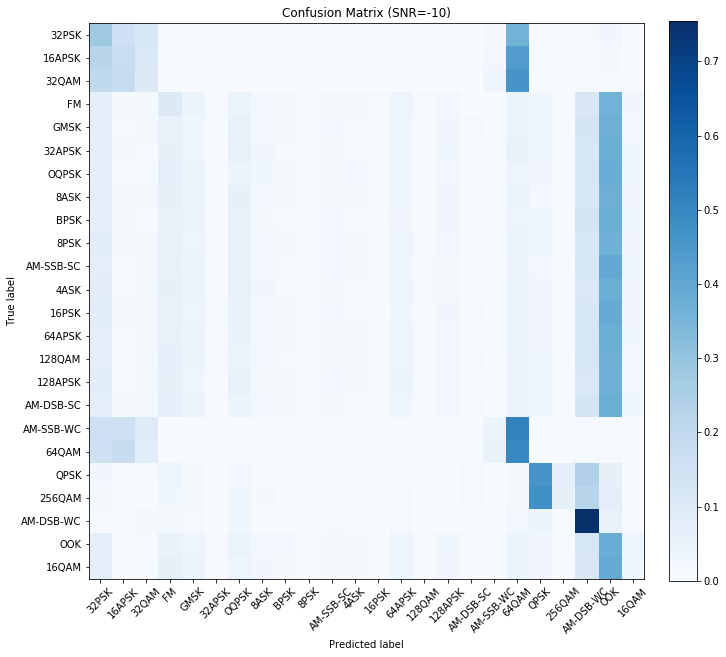

SNR=-10: Overall Accuracy = 0.1295308300073308

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.06      0.02      0.03      2048
      128QAM       0.05      0.01      0.01      2019
      16APSK       0.17      0.17      0.17      2070
       16PSK       0.04      0.01      0.01      2001
       16QAM       0.07      0.03      0.04      2037
      256QAM       0.33      0.06      0.10      2063
      32APSK       0.06      0.01      0.01      2022
       32PSK       0.13      0.28      0.17      2072
       32QAM       0.13      0.10      0.11      2010
        4ASK       0.05      0.01      0.02      2031
      64APSK       0.07      0.04      0.05      2005
       64QAM       0.16      0.50      0.25      2009
        8ASK       0.06      0.02      0.03      2046
        8PSK       0.06      0.01      0.01      2005
   AM-DSB-SC       0.07      0.01      0.01      2080
   AM-DSB-WC       0.24      0.75      0.36      2056
   AM-SSB-S

<Figure size 720x720 with 0 Axes>

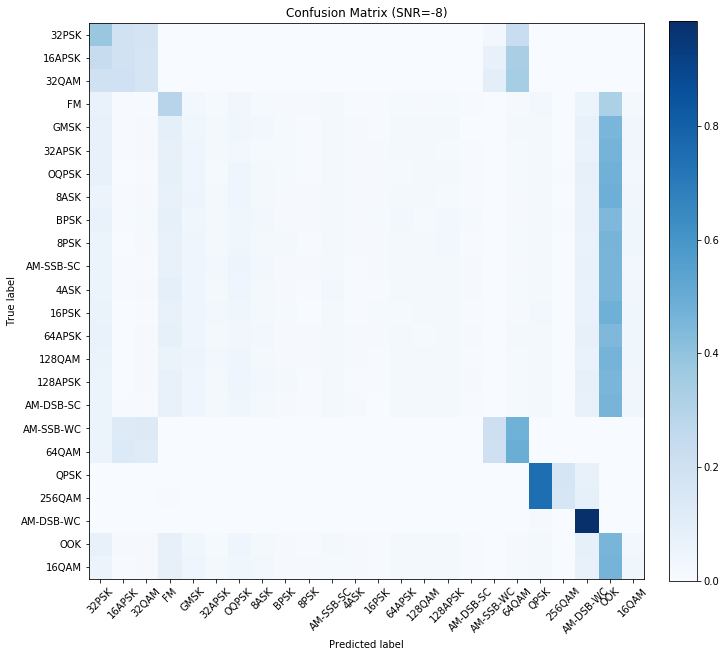

SNR=-8: Overall Accuracy = 0.1810764734534827

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.07      0.02      0.03      2068
      128QAM       0.06      0.02      0.03      2101
      16APSK       0.21      0.19      0.20      1949
       16PSK       0.09      0.01      0.02      2055
       16QAM       0.07      0.04      0.05      2073
      256QAM       0.42      0.15      0.23      2053
      32APSK       0.07      0.02      0.03      2084
       32PSK       0.19      0.38      0.26      2008
       32QAM       0.19      0.17      0.18      2062
        4ASK       0.04      0.00      0.01      2018
      64APSK       0.06      0.02      0.03      2089
       64QAM       0.24      0.49      0.32      2059
        8ASK       0.05      0.02      0.02      2041
        8PSK       0.05      0.01      0.01      2119
   AM-DSB-SC       0.05      0.01      0.01      2004
   AM-DSB-WC       0.43      0.98      0.60      2077
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

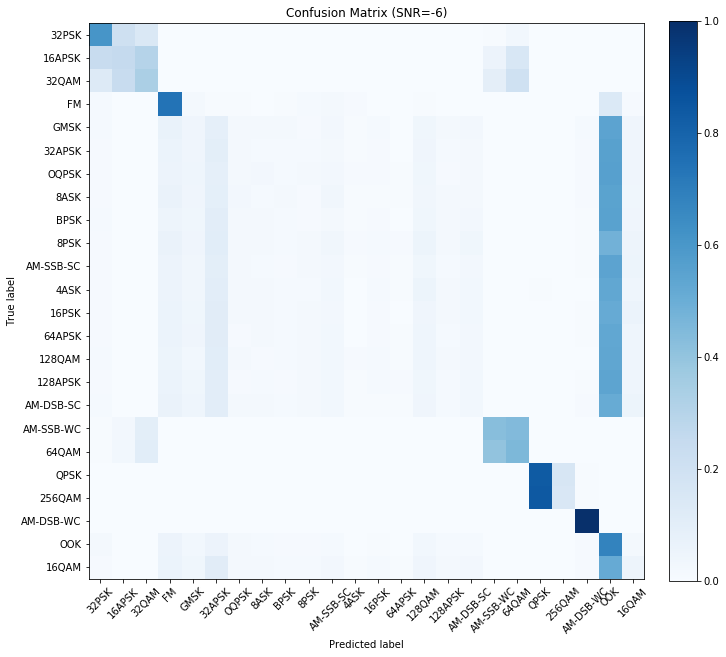

SNR=-6: Overall Accuracy = 0.24359805510534846

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.06      0.01      0.02      2042
      128QAM       0.07      0.05      0.06      2040
      16APSK       0.33      0.25      0.29      2055
       16PSK       0.07      0.01      0.02      2050
       16QAM       0.07      0.05      0.06      2051
      256QAM       0.49      0.15      0.23      2089
      32APSK       0.07      0.10      0.08      2056
       32PSK       0.52      0.61      0.56      2061
       32QAM       0.34      0.34      0.34      2062
        4ASK       0.04      0.00      0.01      2087
      64APSK       0.06      0.00      0.01      2050
       64QAM       0.35      0.45      0.40      2064
        8ASK       0.06      0.02      0.02      2046
        8PSK       0.08      0.02      0.03      2071
   AM-DSB-SC       0.08      0.03      0.04      2073
   AM-DSB-WC       0.88      1.00      0.94      2033
   AM-SSB-S

<Figure size 720x720 with 0 Axes>

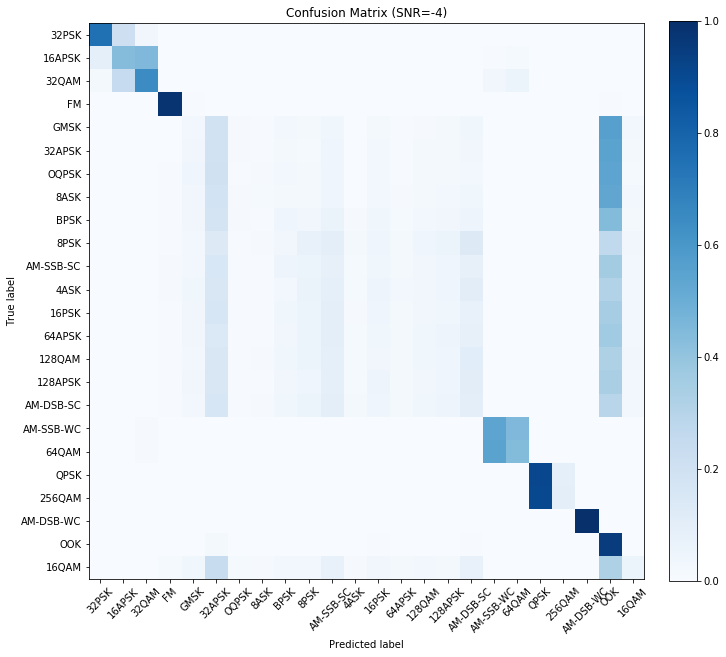

SNR=-4: Overall Accuracy = 0.31041112701984047

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.08      0.04      0.06      2033
      128QAM       0.09      0.04      0.05      2025
      16APSK       0.49      0.44      0.46      2075
       16PSK       0.08      0.04      0.06      2049
       16QAM       0.15      0.06      0.09      2090
      256QAM       0.51      0.10      0.16      2028
      32APSK       0.08      0.19      0.12      2085
       32PSK       0.87      0.75      0.81      2052
       32QAM       0.55      0.65      0.60      2000
        4ASK       0.09      0.01      0.02      2041
      64APSK       0.08      0.02      0.03      2020
       64QAM       0.46      0.44      0.45      2038
        8ASK       0.12      0.01      0.02      2078
        8PSK       0.12      0.07      0.09      2041
   AM-DSB-SC       0.10      0.10      0.10      2080
   AM-DSB-WC       1.00      1.00      1.00      1993
   AM-SSB-S

<Figure size 720x720 with 0 Axes>

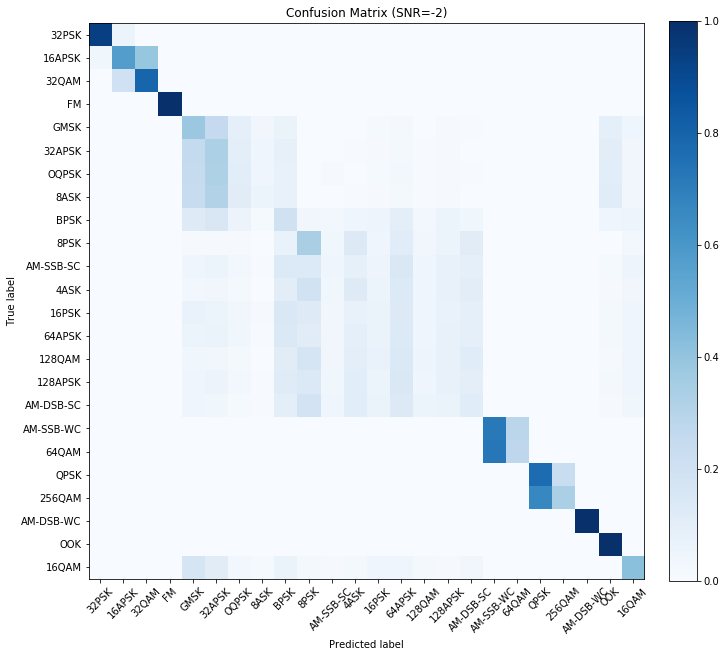

SNR=-2: Overall Accuracy = 0.40799593082400815

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.10      0.07      0.08      1995
      128QAM       0.12      0.05      0.07      2020
      16APSK       0.69      0.57      0.62      2055
       16PSK       0.11      0.06      0.08      2108
       16QAM       0.46      0.42      0.44      2091
      256QAM       0.59      0.34      0.43      2061
      32APSK       0.18      0.33      0.23      2092
       32PSK       0.96      0.94      0.95      1992
       32QAM       0.67      0.80      0.73      2027
        4ASK       0.14      0.12      0.13      2003
      64APSK       0.10      0.13      0.12      2009
       64QAM       0.49      0.27      0.35      2059
        8ASK       0.22      0.05      0.08      2013
        8PSK       0.24      0.34      0.28      2054
   AM-DSB-SC       0.13      0.11      0.12      2066
   AM-DSB-WC       1.00      1.00      1.00      1989
   AM-SSB-S

<Figure size 720x720 with 0 Axes>

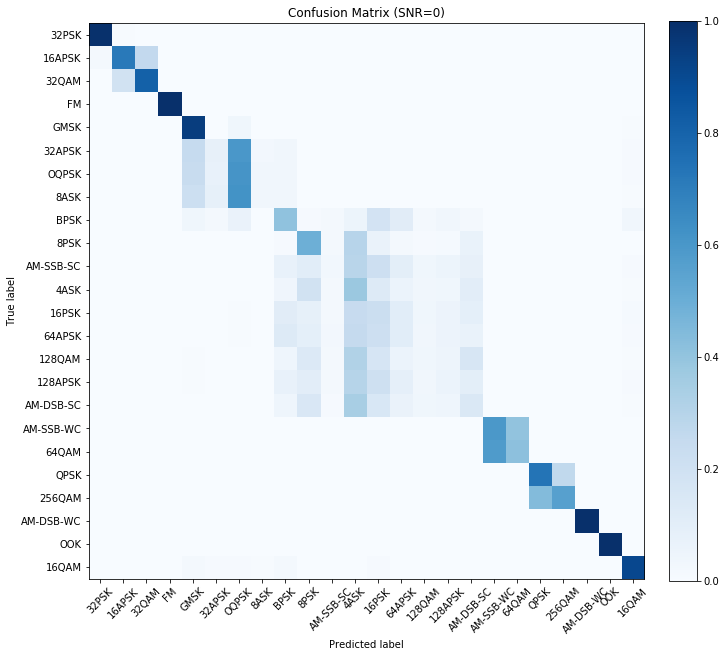

SNR=0: Overall Accuracy = 0.5129034226099689

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.14      0.06      0.08      1996
      128QAM       0.14      0.04      0.06      2032
      16APSK       0.79      0.72      0.75      2061
       16PSK       0.14      0.22      0.17      2053
       16QAM       0.88      0.91      0.89      2007
      256QAM       0.69      0.56      0.62      2127
      32APSK       0.30      0.08      0.13      2038
       32PSK       0.98      0.99      0.98      2016
       32QAM       0.75      0.81      0.78      2022
        4ASK       0.15      0.38      0.22      2035
      64APSK       0.15      0.11      0.13      2046
       64QAM       0.50      0.42      0.46      2061
        8ASK       0.34      0.03      0.06      2064
        8PSK       0.37      0.49      0.42      2099
   AM-DSB-SC       0.17      0.15      0.16      2046
   AM-DSB-WC       1.00      1.00      1.00      2079
   AM-SSB-SC 

<Figure size 720x720 with 0 Axes>

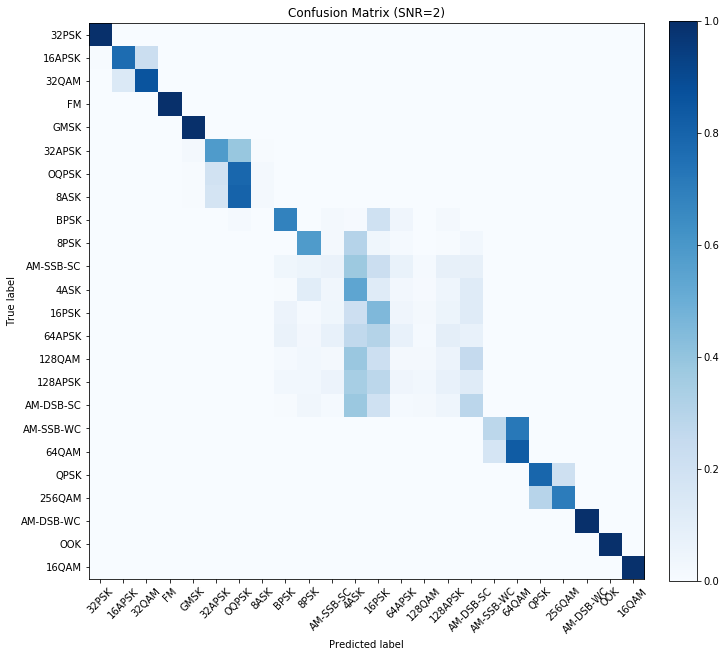

SNR=2: Overall Accuracy = 0.5975304113943395

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.16      0.07      0.10      2069
      128QAM       0.13      0.02      0.03      2060
      16APSK       0.85      0.77      0.81      2086
       16PSK       0.22      0.45      0.30      2071
       16QAM       1.00      1.00      1.00      1977
      256QAM       0.77      0.71      0.73      2007
      32APSK       0.62      0.58      0.60      2049
       32PSK       0.99      1.00      1.00      2071
       32QAM       0.79      0.86      0.83      2066
        4ASK       0.19      0.54      0.28      2066
      64APSK       0.22      0.08      0.11      2049
       64QAM       0.53      0.83      0.65      2047
        8ASK       0.41      0.02      0.03      2038
        8PSK       0.66      0.58      0.62      2085
   AM-DSB-SC       0.26      0.28      0.27      2050
   AM-DSB-WC       1.00      1.00      1.00      2006
   AM-SSB-SC 

<Figure size 720x720 with 0 Axes>

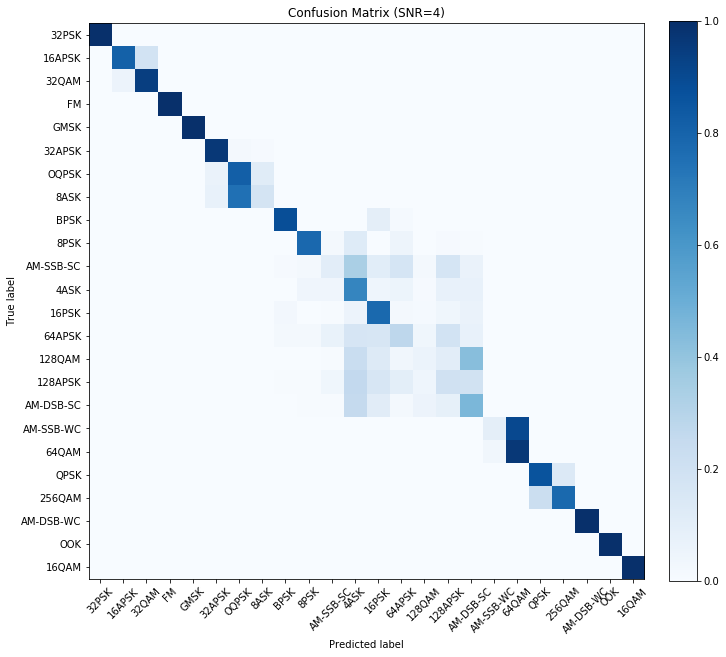

SNR=4: Overall Accuracy = 0.6930333084210314

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.24      0.20      0.21      2146
      128QAM       0.24      0.06      0.10      2022
      16APSK       0.93      0.81      0.87      2068
       16PSK       0.49      0.78      0.60      2082
       16QAM       1.00      1.00      1.00      2064
      256QAM       0.86      0.78      0.82      2097
      32APSK       0.87      0.97      0.92      2014
       32PSK       1.00      1.00      1.00      2040
       32QAM       0.84      0.94      0.89      2100
        4ASK       0.32      0.67      0.43      2072
      64APSK       0.37      0.27      0.32      2044
       64QAM       0.52      0.97      0.67      2034
        8ASK       0.59      0.17      0.27      2099
        8PSK       0.90      0.78      0.84      2071
   AM-DSB-SC       0.34      0.46      0.39      2078
   AM-DSB-WC       1.00      1.00      1.00      2074
   AM-SSB-SC 

<Figure size 720x720 with 0 Axes>

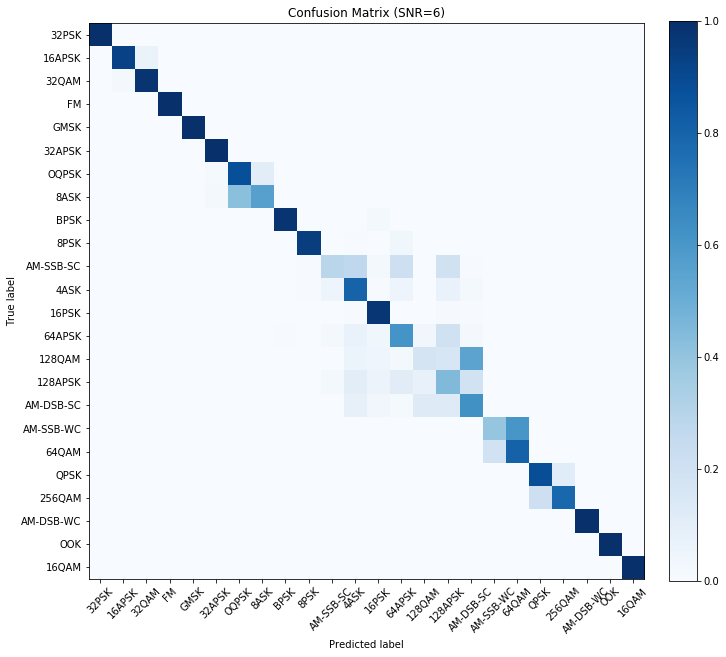

SNR=6: Overall Accuracy = 0.7943088607594937

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.36      0.45      0.40      1988
      128QAM       0.44      0.17      0.25      2134
      16APSK       0.98      0.93      0.96      2091
       16PSK       0.82      0.97      0.89      2039
       16QAM       1.00      1.00      1.00      2065
      256QAM       0.88      0.79      0.83      2056
      32APSK       0.96      1.00      0.98      2083
       32PSK       1.00      1.00      1.00      2050
       32QAM       0.94      0.98      0.96      2033
        4ASK       0.58      0.80      0.67      2080
      64APSK       0.58      0.61      0.59      2038
       64QAM       0.57      0.81      0.67      2071
        8ASK       0.84      0.56      0.67      2102
        8PSK       0.98      0.95      0.97      2044
   AM-DSB-SC       0.44      0.63      0.51      2048
   AM-DSB-WC       1.00      1.00      1.00      2062
   AM-SSB-SC 

<Figure size 720x720 with 0 Axes>

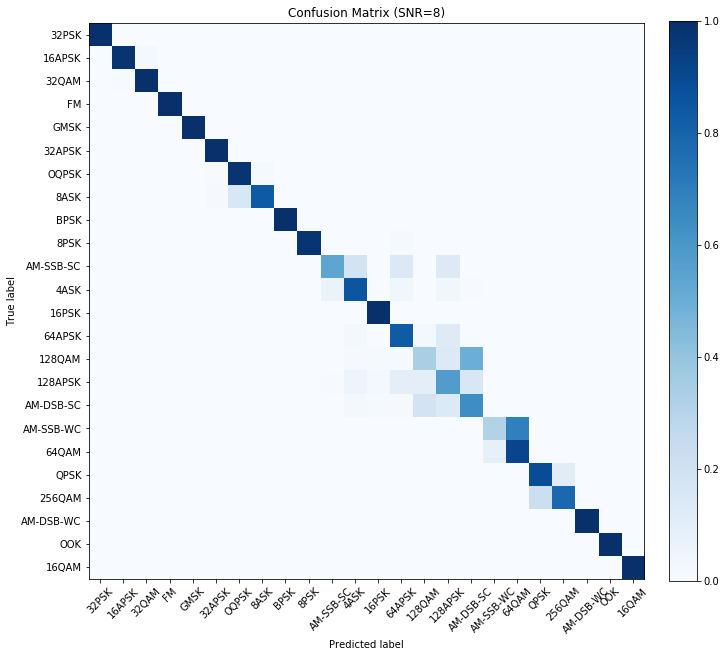

SNR=8: Overall Accuracy = 0.8514893877301364

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.51      0.58      0.54      2067
      128QAM       0.53      0.34      0.41      2068
      16APSK       0.99      0.98      0.99      2031
       16PSK       0.95      1.00      0.97      2014
       16QAM       1.00      1.00      1.00      2066
      256QAM       0.87      0.78      0.83      1976
      32APSK       0.98      1.00      0.99      2082
       32PSK       1.00      1.00      1.00      2023
       32QAM       0.98      0.99      0.99      2028
        4ASK       0.75      0.86      0.80      2031
      64APSK       0.73      0.83      0.78      2074
       64QAM       0.57      0.91      0.70      2039
        8ASK       0.98      0.84      0.90      2026
        8PSK       1.00      0.98      0.99      2058
   AM-DSB-SC       0.49      0.64      0.55      2032
   AM-DSB-WC       1.00      1.00      1.00      2001
   AM-SSB-SC 

<Figure size 720x720 with 0 Axes>

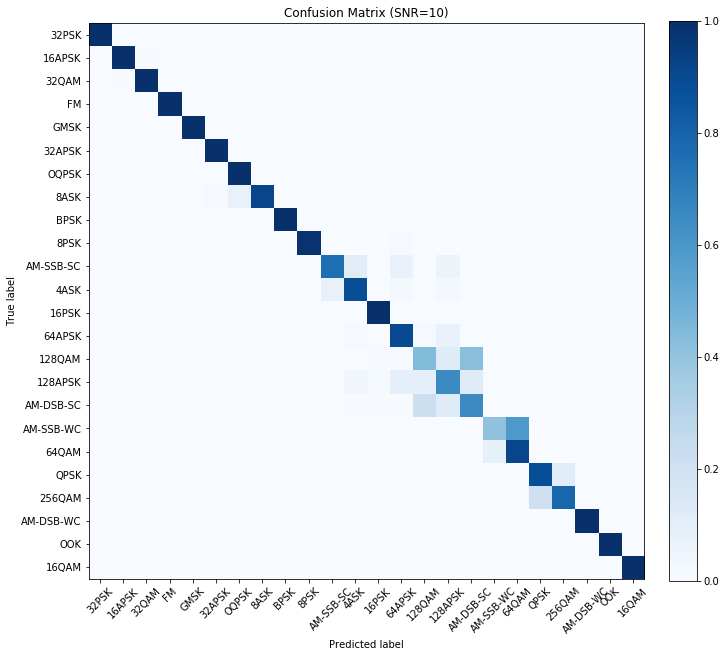

SNR=10: Overall Accuracy = 0.8822413124655661

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.63      0.65      0.64      2022
      128QAM       0.59      0.44      0.50      2079
      16APSK       1.00      1.00      1.00      2042
       16PSK       0.97      1.00      0.98      1988
       16QAM       1.00      1.00      1.00      2055
      256QAM       0.87      0.79      0.83      2034
      32APSK       0.99      1.00      0.99      2022
       32PSK       1.00      1.00      1.00      2034
       32QAM       1.00      1.00      1.00      2049
        4ASK       0.84      0.88      0.86      2060
      64APSK       0.82      0.90      0.86      2041
       64QAM       0.61      0.92      0.73      2054
        8ASK       1.00      0.91      0.95      2039
        8PSK       1.00      0.99      0.99      2082
   AM-DSB-SC       0.54      0.65      0.59      2006
   AM-DSB-WC       1.00      1.00      1.00      2057
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

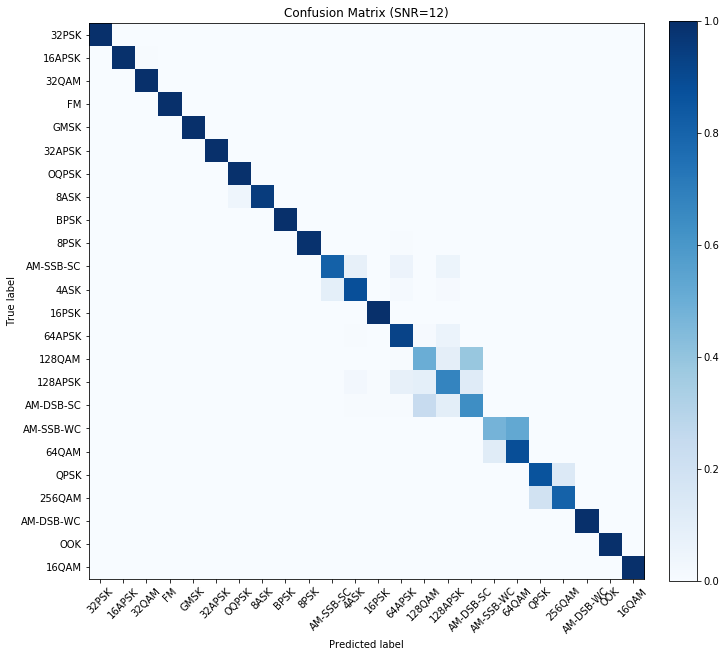

SNR=12: Overall Accuracy = 0.8918483141480937

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.68      0.67      0.68      2064
      128QAM       0.59      0.50      0.54      2017
      16APSK       1.00      0.99      1.00      2041
       16PSK       0.99      1.00      0.99      2050
       16QAM       1.00      1.00      1.00      2012
      256QAM       0.85      0.81      0.83      2011
      32APSK       0.99      1.00      1.00      1990
       32PSK       1.00      1.00      1.00      2068
       32QAM       0.99      1.00      1.00      2068
        4ASK       0.88      0.88      0.88      2037
      64APSK       0.84      0.92      0.88      2025
       64QAM       0.63      0.88      0.74      2042
        8ASK       1.00      0.95      0.98      2023
        8PSK       1.00      0.99      1.00      2136
   AM-DSB-SC       0.55      0.64      0.59      2018
   AM-DSB-WC       1.00      1.00      1.00      2057
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

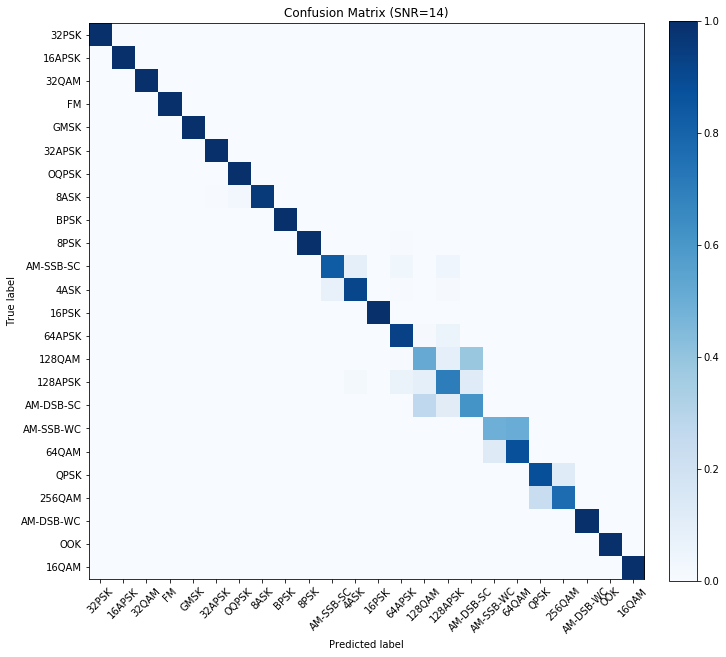

SNR=14: Overall Accuracy = 0.8943383939110261

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.70      0.70      0.70      2088
      128QAM       0.58      0.51      0.55      2085
      16APSK       1.00      1.00      1.00      2059
       16PSK       0.99      1.00      1.00      2035
       16QAM       1.00      1.00      1.00      2028
      256QAM       0.87      0.77      0.81      2070
      32APSK       0.99      1.00      1.00      2120
       32PSK       1.00      1.00      1.00      2066
       32QAM       1.00      1.00      1.00      2034
        4ASK       0.89      0.91      0.90      2102
      64APSK       0.89      0.93      0.91      2085
       64QAM       0.64      0.88      0.74      2008
        8ASK       1.00      0.96      0.98      2013
        8PSK       1.00      1.00      1.00      2031
   AM-DSB-SC       0.55      0.61      0.58      2074
   AM-DSB-WC       1.00      1.00      1.00      2011
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

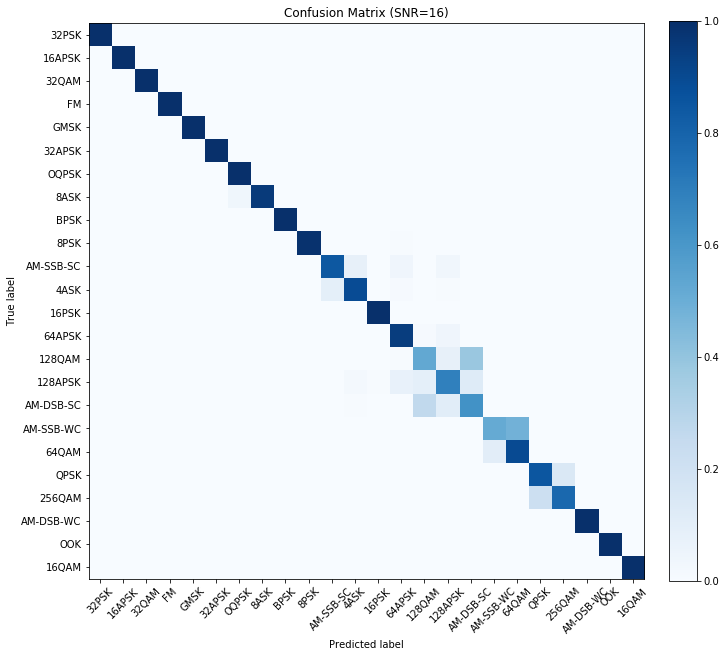

SNR=16: Overall Accuracy = 0.8958631695241213

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.71      0.69      0.70      2017
      128QAM       0.59      0.53      0.56      2062
      16APSK       1.00      1.00      1.00      2034
       16PSK       0.99      1.00      0.99      2034
       16QAM       1.00      1.00      1.00      2042
      256QAM       0.84      0.78      0.81      2015
      32APSK       0.99      1.00      1.00      1999
       32PSK       1.00      1.00      1.00      1996
       32QAM       1.00      1.00      1.00      2001
        4ASK       0.89      0.89      0.89      2069
      64APSK       0.87      0.95      0.91      2022
       64QAM       0.65      0.90      0.75      2055
        8ASK       1.00      0.96      0.98      2059
        8PSK       1.00      0.99      1.00      2019
   AM-DSB-SC       0.55      0.62      0.58      2041
   AM-DSB-WC       1.00      1.00      1.00      2057
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

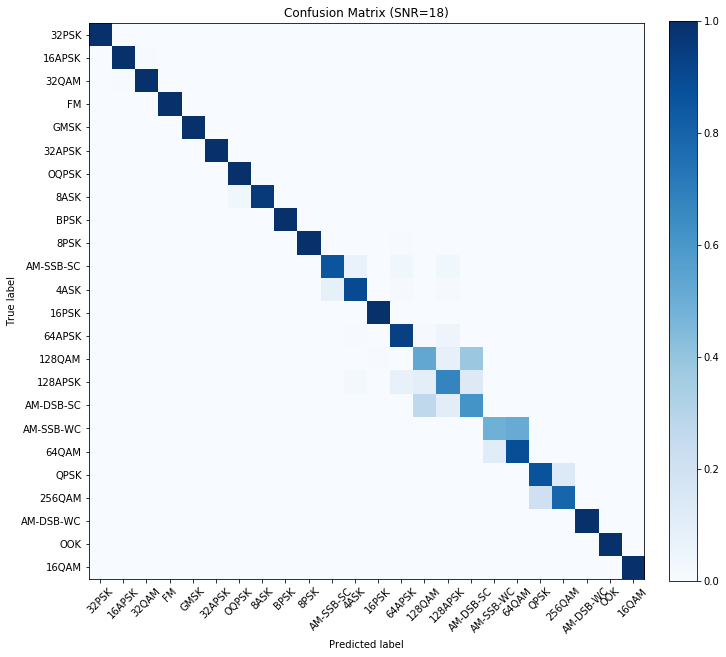

SNR=18: Overall Accuracy = 0.8950684599539561

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.70      0.67      0.69      2039
      128QAM       0.58      0.53      0.55      2091
      16APSK       1.00      0.99      0.99      2025
       16PSK       0.99      1.00      0.99      2066
       16QAM       1.00      1.00      1.00      2076
      256QAM       0.86      0.80      0.82      2033
      32APSK       1.00      1.00      1.00      2061
       32PSK       1.00      1.00      1.00      2056
       32QAM       0.99      1.00      0.99      2064
        4ASK       0.91      0.90      0.90      2061
      64APSK       0.88      0.94      0.91      2123
       64QAM       0.63      0.89      0.74      2065
        8ASK       1.00      0.96      0.98      2099
        8PSK       1.00      0.99      1.00      2019
   AM-DSB-SC       0.54      0.62      0.58      2053
   AM-DSB-WC       1.00      1.00      1.00      2093
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

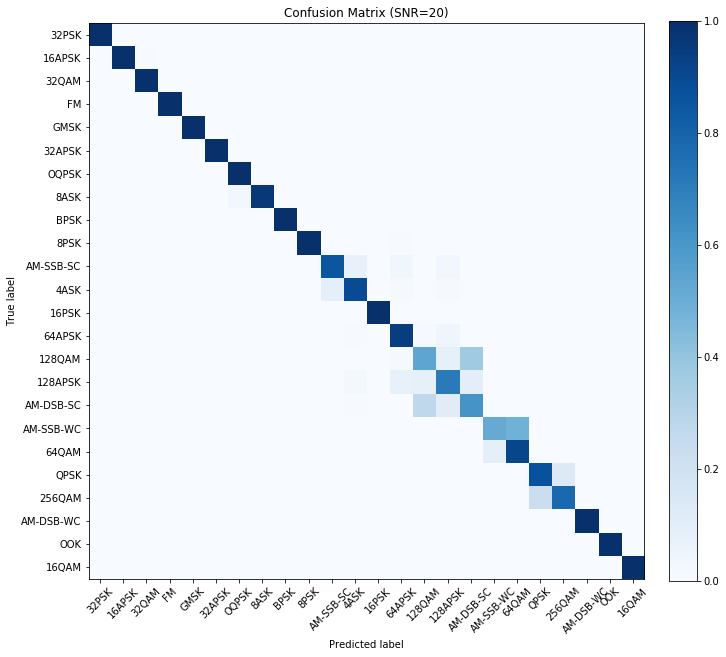

SNR=20: Overall Accuracy = 0.8986512760688483

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.73      0.71      0.72      2054
      128QAM       0.59      0.54      0.56      1992
      16APSK       1.00      1.00      1.00      2046
       16PSK       0.99      1.00      0.99      2071
       16QAM       1.00      1.00      1.00      2067
      256QAM       0.86      0.78      0.82      2075
      32APSK       0.99      1.00      1.00      2061
       32PSK       1.00      1.00      1.00      2015
       32QAM       1.00      1.00      1.00      2024
        4ASK       0.89      0.89      0.89      1966
      64APSK       0.87      0.94      0.91      2036
       64QAM       0.64      0.91      0.75      2013
        8ASK       1.00      0.97      0.98      2050
        8PSK       1.00      0.99      0.99      1985
   AM-DSB-SC       0.57      0.61      0.59      2031
   AM-DSB-WC       1.00      1.00      1.00      2086
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

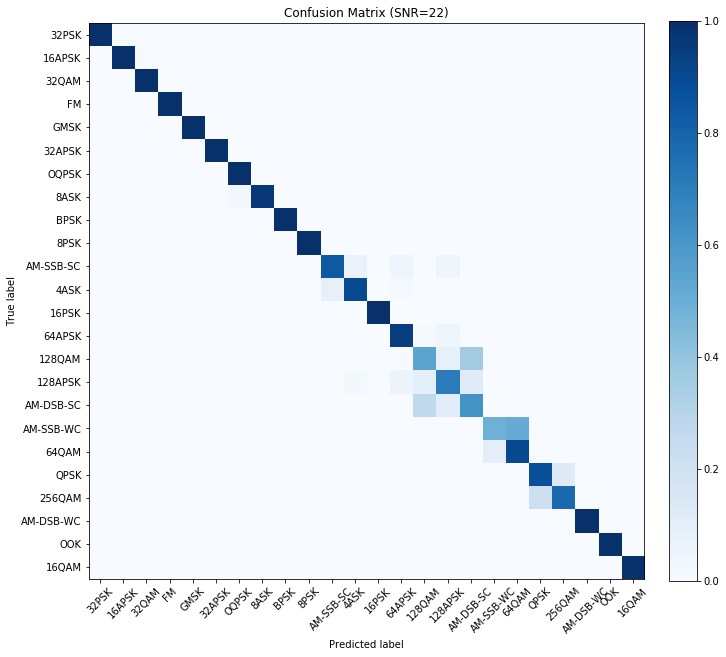

SNR=22: Overall Accuracy = 0.8971443627003911

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.72      0.71      0.71      2105
      128QAM       0.59      0.54      0.57      2041
      16APSK       1.00      0.99      1.00      2088
       16PSK       0.99      1.00      0.99      2048
       16QAM       1.00      1.00      1.00      2037
      256QAM       0.86      0.78      0.82      2041
      32APSK       0.99      1.00      1.00      2021
       32PSK       1.00      1.00      1.00      2058
       32QAM       0.99      1.00      1.00      2077
        4ASK       0.90      0.90      0.90      2083
      64APSK       0.88      0.94      0.91      2099
       64QAM       0.63      0.90      0.74      2037
        8ASK       1.00      0.97      0.98      2012
        8PSK       1.00      1.00      1.00      1984
   AM-DSB-SC       0.56      0.62      0.59      2071
   AM-DSB-WC       1.00      1.00      1.00      2055
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

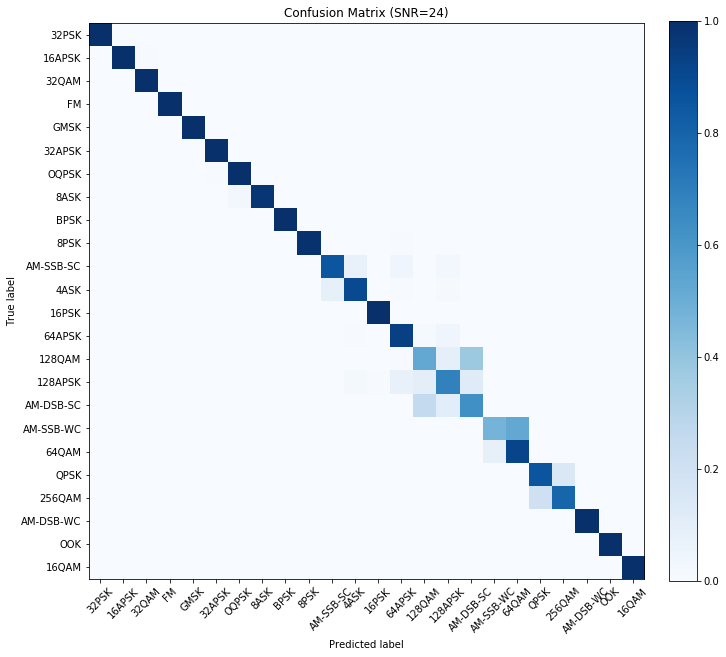

SNR=24: Overall Accuracy = 0.8971074211578475

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.71      0.69      0.70      2058
      128QAM       0.58      0.52      0.55      2055
      16APSK       1.00      0.99      1.00      2047
       16PSK       0.99      1.00      0.99      2072
       16QAM       1.00      1.00      1.00      2045
      256QAM       0.85      0.80      0.82      2004
      32APSK       0.99      1.00      1.00      2043
       32PSK       1.00      1.00      1.00      2066
       32QAM       0.99      1.00      1.00      2035
        4ASK       0.90      0.90      0.90      2023
      64APSK       0.88      0.94      0.91      2017
       64QAM       0.64      0.92      0.76      2083
        8ASK       1.00      0.97      0.99      2001
        8PSK       1.00      0.99      1.00      2050
   AM-DSB-SC       0.56      0.63      0.59      2034
   AM-DSB-WC       1.00      1.00      1.00      2024
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

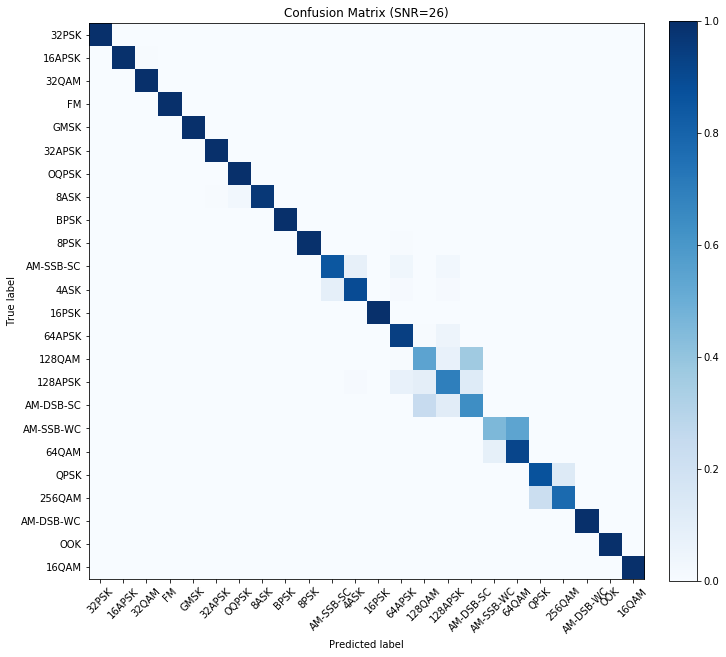

SNR=26: Overall Accuracy = 0.8971846983895176

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.72      0.70      0.71      2066
      128QAM       0.61      0.55      0.57      2033
      16APSK       1.00      0.99      1.00      2092
       16PSK       0.99      1.00      0.99      2046
       16QAM       1.00      1.00      1.00      2044
      256QAM       0.85      0.78      0.81      2031
      32APSK       0.99      1.00      1.00      2042
       32PSK       1.00      1.00      1.00      2077
       32QAM       1.00      1.00      1.00      2071
        4ASK       0.91      0.89      0.90      2111
      64APSK       0.87      0.94      0.90      2030
       64QAM       0.63      0.92      0.75      2064
        8ASK       1.00      0.97      0.98      2032
        8PSK       1.00      1.00      1.00      2046
   AM-DSB-SC       0.57      0.64      0.60      2059
   AM-DSB-WC       1.00      1.00      1.00      2087
   AM-SSB-SC

<Figure size 720x720 with 0 Axes>

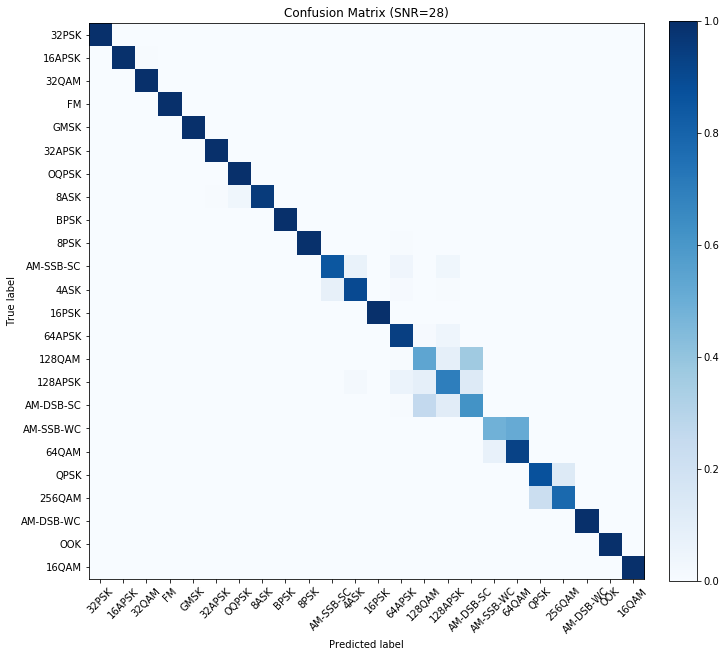

SNR=28: Overall Accuracy = 0.8979571032458

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.72      0.70      0.71      2083
      128QAM       0.60      0.54      0.57      2029
      16APSK       1.00      0.99      1.00      2094
       16PSK       0.99      1.00      0.99      2085
       16QAM       1.00      1.00      1.00      2003
      256QAM       0.86      0.78      0.82      2082
      32APSK       0.99      1.00      1.00      2008
       32PSK       1.00      1.00      1.00      2093
       32QAM       0.99      1.00      1.00      2046
        4ASK       0.90      0.90      0.90      2014
      64APSK       0.88      0.94      0.91      2032
       64QAM       0.64      0.93      0.76      2065
        8ASK       1.00      0.96      0.98      2023
        8PSK       1.00      0.99      1.00      2038
   AM-DSB-SC       0.55      0.62      0.58      2020
   AM-DSB-WC       1.00      1.00      1.00      2054
   AM-SSB-SC   

<Figure size 720x720 with 0 Axes>

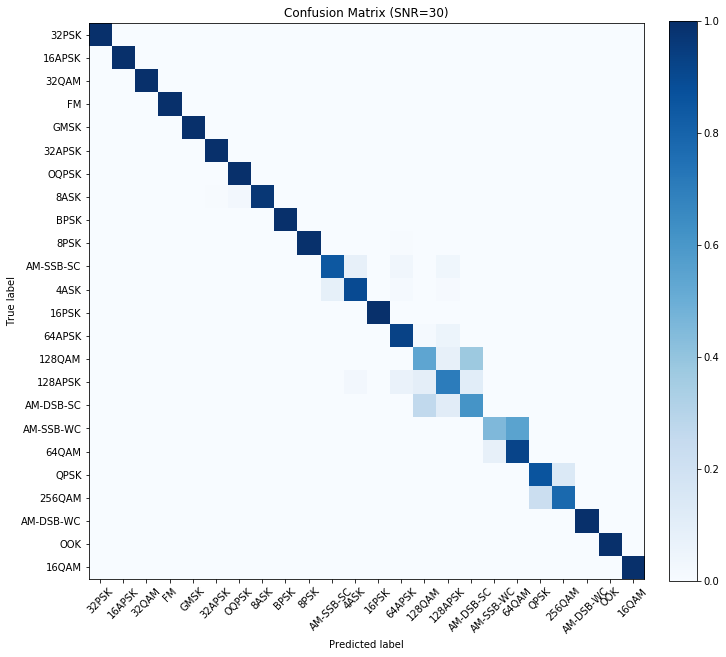

SNR=30: Overall Accuracy = 0.8958729768993104

Clasification report:
              precision    recall  f1-score   support

     128APSK       0.70      0.70      0.70      1999
      128QAM       0.59      0.54      0.56      2017
      16APSK       1.00      1.00      1.00      2009
       16PSK       0.99      1.00      0.99      2048
       16QAM       1.00      1.00      1.00      2044
      256QAM       0.84      0.78      0.81      2019
      32APSK       0.99      1.00      1.00      2059
       32PSK       1.00      1.00      1.00      2060
       32QAM       1.00      1.00      1.00      2026
        4ASK       0.89      0.90      0.89      2031
      64APSK       0.89      0.93      0.91      2024
       64QAM       0.63      0.92      0.75      2022
        8ASK       1.00      0.97      0.98      2064
        8PSK       1.00      0.99      1.00      1987
   AM-DSB-SC       0.56      0.61      0.59      2051
   AM-DSB-WC       1.00      1.00      1.00      2078
   AM-SSB-SC

In [17]:
# Plot confusion matrix for all modulations
acc = {}
num_classes = classes.shape[0]
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = Z[test_inds]
    test_X_i = X_test[np.where(test_SNRs==snr)[0]]
    test_Y_i = Y_test[np.where(test_SNRs==snr)[0]]    
    test_Y_i = np.argmax(test_Y_i, axis=1)
    
    # estimate classes
    test_Y_i_predicted = model.predict(test_X_i)
    test_Y_i_predicted = np.argmax(test_Y_i_predicted, axis=1)
    conf = np.zeros([num_classes,num_classes])
    confnorm = np.zeros([num_classes,num_classes])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = test_Y_i_predicted[i]
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("SNR={}: Overall Accuracy = {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)
    # convert to modulation labels for display
    test_Y_i = classes[test_Y_i]
    test_Y_i_predicted = classes[test_Y_i_predicted]
    print('\nClasification report:\n{}'.format(metrics.classification_report(test_Y_i, test_Y_i_predicted)))    
    # zero_division warnings indicate that some labels did not appear in the predictions at all

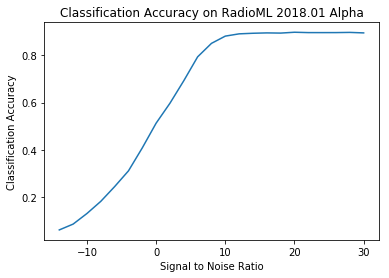

In [24]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on RadioML 2018.01 Alpha")
plt.show()